# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.

### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import pickle
import re
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import xgboost as xgb
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report
from models.custom_transformer import StartingVerbExtractor

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql_table('disaster_responses', con=engine)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26028 entries, 0 to 26027
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      26028 non-null  int64 
 1   message                 26028 non-null  object
 2   original                10038 non-null  object
 3   genre                   26028 non-null  object
 4   related                 26028 non-null  int64 
 5   request                 26028 non-null  int64 
 6   offer                   26028 non-null  int64 
 7   aid_related             26028 non-null  int64 
 8   medical_help            26028 non-null  int64 
 9   medical_products        26028 non-null  int64 
 10  search_and_rescue       26028 non-null  int64 
 11  security                26028 non-null  int64 
 12  military                26028 non-null  int64 
 13  water                   26028 non-null  int64 
 14  food                    26028 non-null  int64 
 15  sh

In [4]:
df.isnull().sum()

id                            0
message                       0
original                  15990
genre                         0
related                       0
request                       0
offer                         0
aid_related                   0
medical_help                  0
medical_products              0
search_and_rescue             0
security                      0
military                      0
water                         0
food                          0
shelter                       0
clothing                      0
money                         0
missing_people                0
refugees                      0
death                         0
other_aid                     0
infrastructure_related        0
transport                     0
buildings                     0
electricity                   0
tools                         0
hospitals                     0
shops                         0
aid_centers                   0
other_infrastructure          0
weather_

In [5]:
# Get X and y
X = df['message']
y = df.iloc[:, 4:]

In [6]:
X.head(5)

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

In [7]:
y.head(5)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Define helper functions

In [39]:
def metrics_evaluation(y_true, y_pred):
    test_results = []
    report_cols = ['column', 'precision_0', 'precision_1', 'recall_0', 'recall_1',
                   'f1_score_0', 'f1_score_1', 'accuracy']
    # Loop through
    for index, col in zip(range(y_true.shape[1]), y_true.columns):
        report_dict = classification_report(y_true.iloc[:,index].values, 
                                            y_pred[:, index],
                                            output_dict=True,
                                            zero_division=0)
        report_df = pd.DataFrame.from_dict(report_dict)
        # Get precision
        try:
            precision_0 = report_df.loc['precision', '0']
        except Exception:
            precision_0 = np.NaN
        try:
            precision_1 = report_df.loc['precision', '1']
        except Exception: 
            precision_1 = np.NaN 
        # Get recall
        try:
            recall_0 = report_df.loc['recall', '0']
        except Exception:
            recall_0 = np.NaN
        try:
            recall_1 = report_df.loc['recall', '1']
        except Exception: 
            recall_1 = np.NaN 
        # Get f1 score
        try:
            f1_score_0 = report_df.loc['f1-score', '0']
        except Exception:
            f1_score_0 = np.NaN
        try:
            f1_score_1 = report_df.loc['f1-score', '1']
        except Exception: 
            f1_score_1 = np.NaN
        # Get accuracy
        accuracy = report_df['accuracy'][0]
        # Collect results
        test_results.append([col, precision_0, precision_1, recall_0, recall_1, f1_score_0, f1_score_1, accuracy])
    # Create df after the loop
    report_df = pd.DataFrame(data=test_results, columns=report_cols)
    # Get mean of metrics
    metrics_tup = namedtuple('Metrics', ['precision_0', 'precision_1', 'recall_0',
                                         'recall_1', 'f1_0', 'f1_1', 'acc'])
    mean_precision_0 = report_df['precision_0'].mean()
    mean_precision_1 = report_df['precision_1'].mean()
    mean_recall_0 = report_df['recall_0'].mean()
    mean_recall_1 = report_df['recall_1'].mean()
    mean_f1_0 = report_df['f1_score_0'].mean()
    mean_f1_1 = report_df['f1_score_1'].mean()
    mean_acc = report_df['accuracy'].mean()
    metrics_mean = metrics_tup(mean_precision_0, mean_precision_1, mean_recall_0, mean_recall_1, 
                               mean_f1_0, mean_f1_1, mean_acc)
    return report_df, metrics_mean

### 3. Explore data

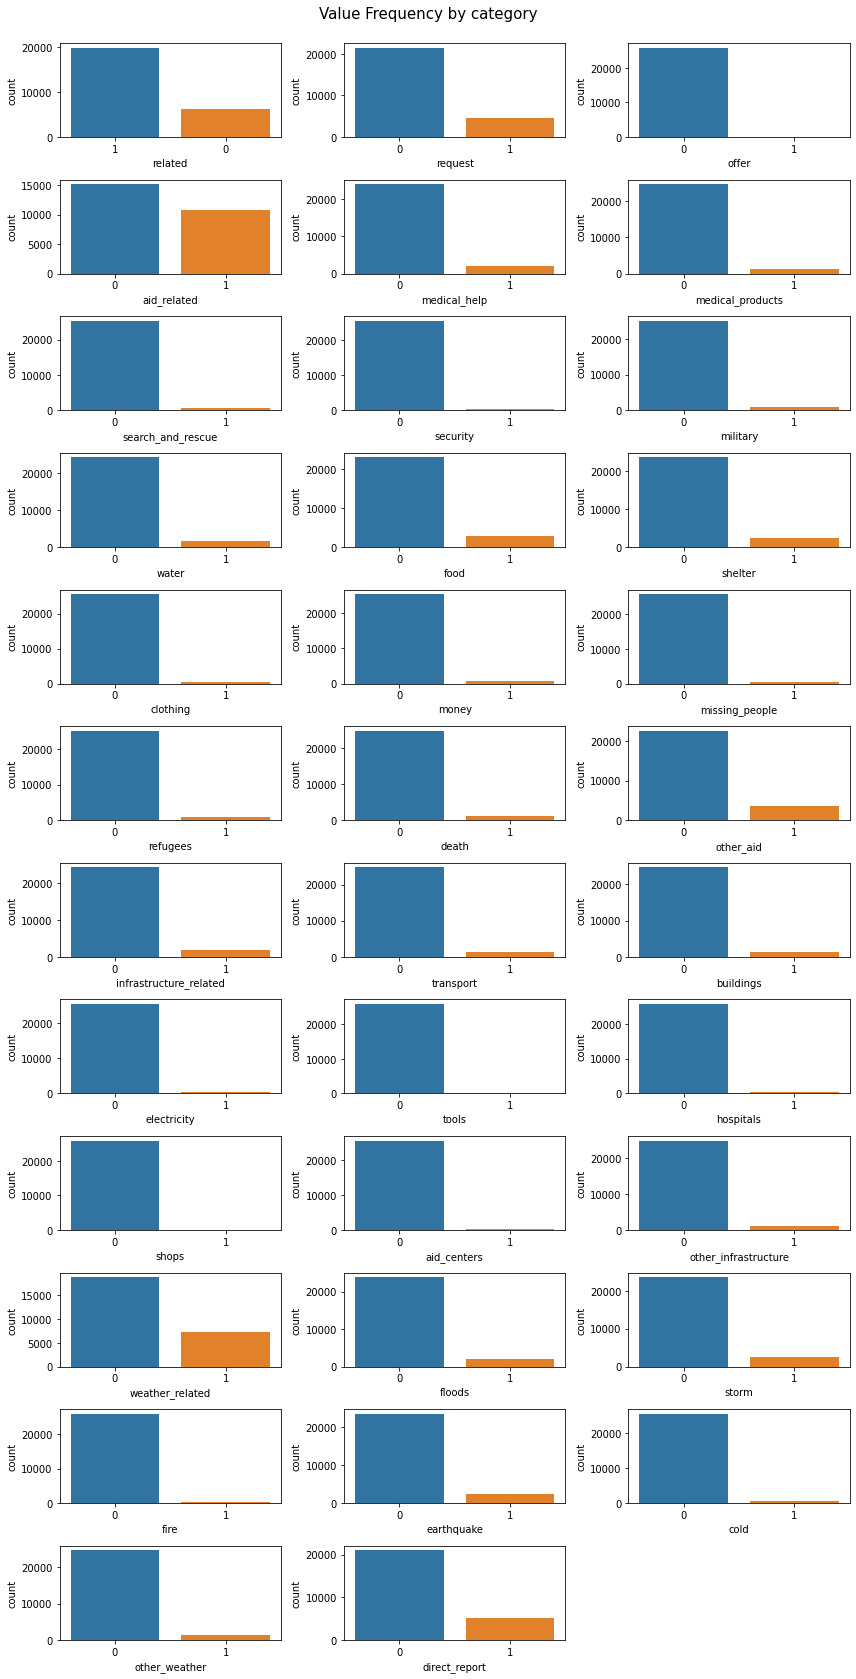

In [21]:
# Visualize frequency
i = 1
plt.figure(figsize=(12, 24))
plt.suptitle('Value Frequency by category', fontsize=15)

for col in y.columns:
    plt.subplot(12, 3, i)
    sns.countplot(data=y, x=col, order=df[col].value_counts().index)
    i+=1
plt.tight_layout(rect=[0, 0.01, 1, 0.98])
plt.show()

**Comment**
- Most variables have unbalanced data, '0' value has significantly more frequency than '1'. This might suggest that our model can predict better for '0' rather than '1'

### 4. Write a tokenization function to process your text data

In [22]:
def tokenize(text):
    # text normalization
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # remove stop words
    tokens = [w for w in tokens if w not in stopwords.words("english")]    
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token
    clean_tokens = []
    for tok in tokens:
        # lemmatize, normalize case, and remove leading/trailing white space
        clean_tok = lemmatizer.lemmatize(tok)
        clean_tokens.append(clean_tok)

    return clean_tokens

In [23]:
# Test function
X.loc[0]

'Weather update - a cold front from Cuba that could pass over Haiti'

In [24]:
# After tokenize
tokenize(X[0])

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']

### 5. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [25]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10)))
])

### 6. Train pipeline
- Split data into train and test sets
- Train pipeline

In [26]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [27]:
# Train dataset
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x0000021098D32430>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10)))])

In [28]:
# Predict
y_pred = pipeline.predict(X_test)

In [29]:
y_pred.shape

(5206, 35)

### 7. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [40]:
report_df, metrics_mean = metrics_evaluation(y_test, y_pred)

In [41]:
report_df

,column,precision_0,precision_1,recall_0,recall_1,f1_score_0,f1_score_1,accuracy
0,related,0.646522,0.842920,0.454691,0.921697,0.533898,0.880550,0.809835
1,request,0.896766,0.782123,0.972816,0.465632,0.933244,0.583739,0.884940
2,offer,0.995198,0.000000,1.000000,0.000000,0.997593,0.000000,0.995198
3,aid_related,0.757674,0.734323,0.841639,0.619202,0.797453,0.671867,0.749520
4,medical_help,0.925024,0.647887,0.994764,0.106729,0.958628,0.183267,0.921245
5,medical_products,0.956530,0.754717,0.997369,0.151515,0.976523,0.252366,0.954476
6,search_and_rescue,0.971341,0.285714,0.999011,0.013245,0.984981,0.025316,0.970419
7,security,0.979627,0.000000,0.999412,0.000000,0.989421,0.000000,0.979063
8,military,0.970054,0.666667,0.998012,0.114286,0.983835,0.195122,0.968306
9,water,0.958399,0.848101,0.995064,0.389535,0.976387,0.533865,0.955052


In [42]:
# Print average for each metrics
metrics_mean

Metrics(precision_0=0.9416085046225872, precision_1=0.5442430561457497, recall_0=0.9744857425145876, recall_1=0.20280723526989802, f1_0=0.956938235335149, f1_1=0.2639837222379713, acc=0.9435760935184678)

### 8. Improve your model
Use grid search to find better parameters. 

In [20]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001DB04409940>)),
  ('tfidf', TfidfTransformer()),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10)))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001DB04409940>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10)),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True

In [21]:
# specify parameters for grid search
parameters = { 
        'tfidf__smooth_idf': [True, False],
        'clf__estimator__n_estimators': [10],
        'clf__estimator__min_samples_split': [2, 10]
}
cv = GridSearchCV(pipeline, param_grid=parameters, verbose=4, cv=3)

### 9. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [22]:
cv.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__smooth_idf=True;, score=0.234 total time= 2.4min
[CV 2/2] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__smooth_idf=True;, score=0.240 total time= 2.4min
[CV 1/2] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__smooth_idf=False;, score=0.235 total time= 2.4min
[CV 2/2] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=10, tfidf__smooth_idf=False;, score=0.243 total time= 2.4min
[CV 1/2] END clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__smooth_idf=True;, score=0.216 total time= 2.3min
[CV 2/2] END clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__smooth_idf=True;, score=0.238 total time= 2.3min
[CV 1/2] END clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__smooth_idf=F

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000001DB04409940>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10)))]),
             param_grid={'clf__estimator__min_samples_split': [2, 10],
                         'clf__estimator__n_estimators': [10],
                         'tfidf__smooth_idf': [True, False]},
             verbose=4)

In [23]:
# Predict
y_pred = cv.predict(X_test)

In [24]:
y_pred.shape

(5206, 35)

In [25]:
report_df, metrics_mean = metrics_evaluation(y_test, y_pred)

In [26]:
report_df

,column,f1_score_0,f1_score_1,accuracy
0,related,0.521412,0.877278,0.804648
1,request,0.932860,0.568166,0.883788
2,offer,0.997593,0.000000,0.995198
3,aid_related,0.799258,0.670388,0.750480
4,medical_help,0.959142,0.229008,0.922397
5,medical_products,0.977025,0.261146,0.955436
6,search_and_rescue,0.985459,0.096970,0.971379
7,security,0.989713,0.018519,0.979639
8,military,0.983648,0.160804,0.967922
9,water,0.975802,0.514170,0.953899


In [27]:
metrics_mean

Metrics(acc=0.9433894956369027, f1_0=0.9565953014561497, f1_1=0.2642707167071541)

### 10. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [117]:
# Add starting verb feature 
new_pipeline = Pipeline([
                        ('features', FeatureUnion ([
                            ('text_pipeline', Pipeline ([
                                                ('vect', CountVectorizer(tokenizer=tokenize)),
                                                ('tfidf', TfidfTransformer())
                                            ])),      
                            ('starting_verb', StartingVerbExtractor ())   
                                    ])),        
                        ('clf', MultiOutputClassifier (xgb.XGBClassifier(eval_metric='logloss')))
                        ])

In [118]:
new_pipeline.get_params()

{'memory': None,
 'steps': [('features',
   FeatureUnion(transformer_list=[('text_pipeline',
                                   Pipeline(steps=[('vect',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x000001DB04409940>)),
                                                   ('tfidf',
                                                    TfidfTransformer())])),
                                  ('starting_verb', StartingVerbExtractor())])),
  ('clf',
   MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None, gamma=None,
                                                 gpu_id=None,
                                                 importance_type='gain',
                                                 int

In [125]:
# Grid Search
new_parameters = {
              'clf__estimator__min_child_weight' : [1, 5],
              'clf__estimator__gamma' : [0, 1],
              'clf__estimator__max_depth': [6, 3],
              'clf__estimator__use_label_encoder': [False]
             }
new_cv = GridSearchCV(new_pipeline, param_grid=new_parameters, verbose=4, cv=3)

In [126]:
new_cv.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[09:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:51:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:51:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:51:07]

[09:52:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:52:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:52:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:52:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[09:56:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:01:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:05:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:05:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:05:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:06:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:06:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:10:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:11:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:11:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:11:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:15:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:15:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:15:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:19:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:19:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:23:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:23:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:27:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:27:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:31:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:32:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:33:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:36:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:36:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:37:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:45:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:45:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:49:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:49:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:56:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[10:57:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:57:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[11:03:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:03:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:03:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text_pipeline',
                                                                        Pipeline(steps=[('vect',
                                                                                         CountVectorizer(tokenizer=<function tokenize at 0x000001DB04409940>)),
                                                                                        ('tfidf',
                                                                                         TfidfTransformer())])),
                                                                       ('starting_verb',
                                                                        StartingVerbExtractor())])),
                                       ('clf',
                                        MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                

In [132]:
# Get the best params
new_cv.best_params_

{'clf__estimator__gamma': 1,
 'clf__estimator__max_depth': 6,
 'clf__estimator__min_child_weight': 5,
 'clf__estimator__use_label_encoder': False}

In [127]:
# Predict
new_y_pred = new_cv.predict(X_test)

In [128]:
new_report_df, new_metrics_mean = metrics_evaluation(y_test, new_y_pred)

In [129]:
new_report_df

,column,f1_score_0,f1_score_1,accuracy
0,related,0.478075,0.885741,0.812524
1,request,0.942316,0.666667,0.901652
2,offer,0.997593,0.000000,0.995198
3,aid_related,0.820942,0.707786,0.777949
4,medical_help,0.960212,0.360656,0.925086
5,medical_products,0.978226,0.455000,0.958125
6,search_and_rescue,0.986800,0.270270,0.974068
7,security,0.989613,0.036036,0.979447
8,military,0.985116,0.434457,0.970995
9,water,0.980901,0.698873,0.964080


In [130]:
new_metrics_mean

Metrics(acc=0.949909445145711, f1_0=0.9588161892555083, f1_1=0.43378766781517647)

### 9. Export your model as a pickle file

In [134]:
with open('models/disaster_response_classifier.pkl', 'wb') as f:
    pickle.dump(new_cv, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.